In [1]:
%matplotlib inline

import os
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from prettytable import PrettyTable
from IPython.display import Image

from sklearn.preprocessing import LabelEncoder

from keras.models import Model
from keras.regularizers import l2
from keras.constraints import max_norm
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Dropout, Flatten, Activation
from keras.layers import Conv1D, Add, MaxPooling1D, BatchNormalization
from keras.layers import Embedding, Bidirectional,LSTM, GlobalMaxPooling1D

Using TensorFlow backend.
c:\users\anindya vedant\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\anindya vedant\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\anindya vedant\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np

In [2]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

In [3]:
data_path = 'pfam-seed-random-split/random_split/'
print('Available data', os.listdir(data_path))

Available data ['dev', 'random_split', 'test', 'train']


In [4]:
def read_data(partition):
  data = []
  for fn in os.listdir(os.path.join(data_path, partition)):
    with open(os.path.join(data_path, partition, fn)) as f:
      data.append(pd.read_csv(f, index_col=None))
  return pd.concat(data)

In [5]:
df_train = read_data('train')
df_val = read_data('dev')
df_test = read_data('test')

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1086741 entries, 0 to 13514
Data columns (total 5 columns):
family_id           1086741 non-null object
sequence_name       1086741 non-null object
family_accession    1086741 non-null object
aligned_sequence    1086741 non-null object
sequence            1086741 non-null object
dtypes: object(5)
memory usage: 49.7+ MB


In [7]:
df_train.head()

,family_id,sequence_name,family_accession,aligned_sequence,sequence
0,GMC_oxred_C,A4WZS5_RHOS5/416-539,PF05199.13,PHPE.SRIRLST.RRDAHGMP.....IP.RIESRLGP............,PHPESRIRLSTRRDAHGMPIPRIESRLGPDAFARLRFMARTCRAIL...
1,DUF2887,K9QI92_9NOSO/3-203,PF11103.8,RDSIYYQIFKRFPALIFEL..VD.NRPPQAQNYRFESVEVKETAFR...,RDSIYYQIFKRFPALIFELVDNRPPQAQNYRFESVEVKETAFRIDG...
2,zf-IS66,Q92LC9_RHIME/32-75,PF13005.7,.TCCPDCGG.E..LRLVGED.AS....EILDMI.AAQMKVIEVARL...,TCCPDCGGELRLVGEDASEILDMIAAQMKVIEVARLKKSCRCCE
3,Asp_decarbox,X2GQZ4_9BACI/1-115,PF02261.16,MLRMMMNSKIHRATVTEADLNYVGSITIDEDILDAVGMLPNEKVHI...,MLRMMMNSKIHRATVTEADLNYVGSITIDEDILDAVGMLPNEKVHI...
4,Filamin,A7SQM3_NEMVE/342-439,PF00630.19,TACPKQ.CTA....RGLG.............LK.AAPVT.QPT..R...,TACPKQCTARGLGLKAAPVTQPTRFVVILNDCHGQPLGRSEGELEV...


In [8]:
df_train.head(1)['sequence'].values[0]

'PHPESRIRLSTRRDAHGMPIPRIESRLGPDAFARLRFMARTCRAILAAAGCAAPFEEFSSADAFSSTHVFGTCRMGHDPMRNVVDGWGRSHRWPNLFVADASLFPSSGGGESPGLTIQALALRT'

In [9]:
print('Train size: ', len(df_train))
print('Val size: ', len(df_val))
print('Test size: ', len(df_test))

Train size:  1086741
Val size:  126171
Test size:  126171


In [10]:
def calc_unique_cls(train, test, val):
  """
  Prints # unique classes in data sets.
  """
  train_unq = np.unique(train['family_accession'].values)
  val_unq = np.unique(val['family_accession'].values)
  test_unq = np.unique(test['family_accession'].values)

  print('Number of unique classes in Train: ', len(train_unq))
  print('Number of unique classes in Val: ', len(val_unq))
  print('Number of unique classes in Test: ', len(test_unq))

In [11]:
calc_unique_cls(df_train, df_test, df_val)

Number of unique classes in Train:  17929
Number of unique classes in Val:  13071
Number of unique classes in Test:  13071


In [12]:
# Length of sequence in train data.
df_train['seq_char_count']= df_train['sequence'].apply(lambda x: len(x))
df_val['seq_char_count']= df_val['sequence'].apply(lambda x: len(x))
df_test['seq_char_count']= df_test['sequence'].apply(lambda x: len(x))

In [13]:
def plot_seq_count(df, data_name):
  sns.distplot(df['seq_char_count'].values)
  plt.title(f'Sequence char count: {data_name}')
  plt.grid(True)

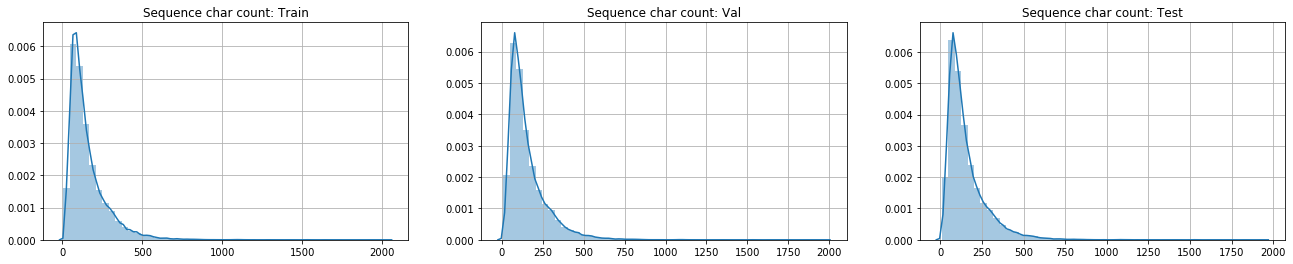

In [14]:
plt.subplot(1, 3, 1)
plot_seq_count(df_train, 'Train')

plt.subplot(1, 3, 2)
plot_seq_count(df_val, 'Val')

plt.subplot(1, 3, 3)
plot_seq_count(df_test, 'Test')

plt.subplots_adjust(right=3.0)
plt.show()

In [15]:
def get_code_freq(df, data_name):
  
  df = df.apply(lambda x: " ".join(x))
  
  codes = []
  for i in df: 
    codes.extend(i)

  codes_dict= Counter(codes)
  codes_dict.pop(' ')
  
  print(f'Codes: {data_name}')
  print(f'Total unique codes: {len(codes_dict.keys())}')

  df = pd.DataFrame({'Code': list(codes_dict.keys()), 'Freq': list(codes_dict.values())})
  return df.sort_values('Freq', ascending=False).reset_index()[['Code', 'Freq']]

In [16]:
train_code_freq = get_code_freq(df_train['sequence'], 'Train')
train_code_freq

Codes: Train
Total unique codes: 25


,Code,Freq
0,L,17062816
1,A,14384873
2,V,11913147
3,G,11845579
4,E,10859966
5,S,10597822
6,I,10234455
7,R,9406165
8,D,9371097
9,K,9127832


In [17]:
val_code_freq = get_code_freq(df_val['sequence'], 'Val')
val_code_freq

Codes: Val
Total unique codes: 22


,Code,Freq
0,L,1967025
1,A,1667703
2,V,1382128
3,G,1376124
4,E,1249356
5,S,1210750
6,I,1185722
7,R,1085950
8,D,1080572
9,K,1047638


In [18]:
test_code_freq = get_code_freq(df_test['sequence'], 'Test')
test_code_freq

Codes: Test
Total unique codes: 24


,Code,Freq
0,L,1967046
1,A,1668137
2,V,1380962
3,G,1375349
4,E,1251000
5,S,1210559
6,I,1184239
7,R,1085786
8,D,1078379
9,K,1045957


In [19]:
def plot_code_freq(df, data_name):
  
  plt.title(f'Code frequency: {data_name}')
  sns.barplot(x='Code', y='Freq', data=df)

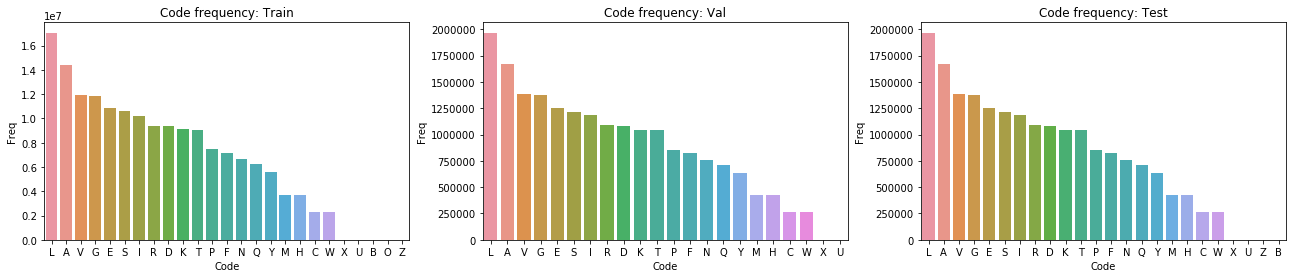

In [20]:
plt.subplot(1, 3, 1)
plot_code_freq(train_code_freq, 'Train')

plt.subplot(1, 3, 2)
plot_code_freq(val_code_freq, 'Val')

plt.subplot(1, 3, 3)
plot_code_freq(test_code_freq, 'Test')

plt.subplots_adjust(right=3.0)
plt.show()

In [21]:
df_train.groupby('family_id').size().sort_values(ascending=False).head(20)

family_id
Methyltransf_25    3637
LRR_1              1927
Acetyltransf_7     1761
His_kinase         1537
Bac_transf         1528
Lum_binding        1504
DNA_binding_1      1345
Chromate_transp    1265
Lipase_GDSL_2      1252
DnaJ_CXXCXGXG      1210
SRP54_N            1185
WD40               1173
OTCace_N           1171
PEP-utilizers      1147
Glycos_trans_3N    1138
THF_DHG_CYH        1113
Prenyltransf       1104
HTH_1              1064
Maf                1061
DHH                1057
dtype: int64

In [22]:
df_val.groupby('family_id').size().sort_values(ascending=False).head(20)

family_id
Methyltransf_25    454
LRR_1              240
Acetyltransf_7     219
His_kinase         192
Bac_transf         190
Lum_binding        187
DNA_binding_1      168
Chromate_transp    157
Lipase_GDSL_2      156
DnaJ_CXXCXGXG      151
SRP54_N            148
OTCace_N           146
WD40               146
PEP-utilizers      143
Glycos_trans_3N    142
Prenyltransf       138
THF_DHG_CYH        138
HTH_1              133
Maf                132
DHH                131
dtype: int64

In [23]:
df_test.groupby('family_id').size().sort_values(ascending=False).head(20)

family_id
Methyltransf_25    454
LRR_1              240
Acetyltransf_7     219
His_kinase         192
Bac_transf         190
Lum_binding        187
DNA_binding_1      168
Chromate_transp    157
Lipase_GDSL_2      156
DnaJ_CXXCXGXG      151
SRP54_N            148
OTCace_N           146
WD40               146
PEP-utilizers      143
Glycos_trans_3N    142
Prenyltransf       138
THF_DHG_CYH        138
HTH_1              133
Maf                132
DHH                131
dtype: int64

In [24]:
classes = df_train['family_accession'].value_counts()[:1000].index.tolist()
len(classes)

1000

In [25]:
train_sm = df_train.loc[df_train['family_accession'].isin(classes)].reset_index()
val_sm = df_val.loc[df_val['family_accession'].isin(classes)].reset_index()
test_sm = df_test.loc[df_test['family_accession'].isin(classes)].reset_index()

print('Data size after considering 1000 classes for each data split:')
print('Train size :', len(train_sm))
print('Val size :', len(val_sm))
print('Test size :', len(test_sm))

Data size after considering 1000 classes for each data split:
Train size : 439493
Val size : 54378
Test size : 54378


In [26]:
calc_unique_cls(train_sm, test_sm, val_sm)

Number of unique classes in Train:  1000
Number of unique classes in Val:  1000
Number of unique classes in Test:  1000


In [27]:
codes = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
         'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

def create_dict(codes):
  char_dict = {}
  for index, val in enumerate(codes):
    char_dict[val] = index+1

  return char_dict

char_dict = create_dict(codes)

print(char_dict)
print("Dict Length:", len(char_dict))

{'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20}
Dict Length: 20


In [28]:
def integer_encoding(data):
  """
  - Encodes code sequence to integer values.
  - 20 common amino acids are taken into consideration
    and rest 4 are categorized as 0.
  """
  
  encode_list = []
  for row in data['sequence'].values:
    row_encode = []
    for code in row:
      row_encode.append(char_dict.get(code, 0))
    encode_list.append(np.array(row_encode))
  
  return encode_list

In [29]:
train_encode = integer_encoding(train_sm) 
val_encode = integer_encoding(val_sm) 
test_encode = integer_encoding(test_sm) 

In [30]:
max_length = 100
train_pad = pad_sequences(train_encode, maxlen=max_length, padding='post', truncating='post')
val_pad = pad_sequences(val_encode, maxlen=max_length, padding='post', truncating='post')
test_pad = pad_sequences(test_encode, maxlen=max_length, padding='post', truncating='post')

train_pad.shape, val_pad.shape, test_pad.shape

((439493, 100), (54378, 100), (54378, 100))

In [31]:
train_ohe = to_categorical(train_pad)
val_ohe = to_categorical(val_pad)
test_ohe = to_categorical(test_pad)

train_ohe.shape, test_ohe.shape, test_ohe.shape 

((439493, 100, 21), (54378, 100, 21), (54378, 100, 21))

In [32]:
le = LabelEncoder()

y_train_le = le.fit_transform(train_sm['family_accession'])
y_val_le = le.transform(val_sm['family_accession'])
y_test_le = le.transform(test_sm['family_accession'])

y_train_le.shape, y_val_le.shape, y_test_le.shape

((439493,), (54378,), (54378,))

In [33]:
print('Total classes: ', len(le.classes_))

Total classes:  1000


In [34]:
y_train = to_categorical(y_train_le)
y_val = to_categorical(y_val_le)
y_test = to_categorical(y_test_le)

y_train.shape, y_val.shape, y_test.shape

((439493, 1000), (54378, 1000), (54378, 1000))

In [35]:
plt.style.use('ggplot')

def plot_history(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  x = range(1, len(acc) + 1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(x, acc, 'b', label='Training acc')
  plt.plot(x, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

In [36]:
def display_model_score(model, train, val, test, batch_size):

  train_score = model.evaluate(train[0], train[1], batch_size=batch_size, verbose=1)
  print('Train loss: ', train_score[0])
  print('Train accuracy: ', train_score[1])
  print('-'*70)

  val_score = model.evaluate(val[0], val[1], batch_size=batch_size, verbose=1)
  print('Val loss: ', val_score[0])
  print('Val accuracy: ', val_score[1])
  print('-'*70)
  
  test_score = model.evaluate(test[0], test[1], batch_size=batch_size, verbose=1)
  print('Test loss: ', test_score[0])
  print('Test accuracy: ', test_score[1])

In [37]:
x_input = Input(shape=(100,))
emb = Embedding(21, 128, input_length=max_length)(x_input)
bi_rnn = Bidirectional(LSTM(64, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01)))(emb)
x = Dropout(0.3)(bi_rnn)

x_output = Dense(1000, activation='softmax')(x)

model1 = Model(inputs=x_input, outputs=x_output)
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

model1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 128)          2688      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              129000    
Total params: 230,504
Trainable params: 230,504
Non-trainable params: 0
_________________________________________________________________


In [38]:
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

In [39]:
history1 = model1.fit(
    train_pad, y_train,
    epochs=50, batch_size=256,
    validation_data=(val_pad, y_val),
    callbacks=[es]
    )

Train on 439493 samples, validate on 54378 samples
Epoch 1/50
439493/439493 [==============================] - 531s 1ms/step - loss: 5.5357 - acc: 0.1088 - val_loss: 3.6296 - val_acc: 0.3310
Epoch 2/50
439493/439493 [==============================] - 540s 1ms/step - loss: 2.8647 - acc: 0.4738 - val_loss: 2.0723 - val_acc: 0.6547
Epoch 3/50
439493/439493 [==============================] - 541s 1ms/step - loss: 1.8791 - acc: 0.6700 - val_loss: 1.3717 - val_acc: 0.7920
Epoch 4/50
439493/439493 [==============================] - 539s 1ms/step - loss: 1.4300 - acc: 0.7565 - val_loss: 1.0372 - val_acc: 0.8531
Epoch 5/50
439493/439493 [==============================] - 532s 1ms/step - loss: 1.1806 - acc: 0.8030 - val_loss: 0.8867 - val_acc: 0.8802
Epoch 6/50
439493/439493 [==============================] - 530s 1ms/step - loss: 1.0259 - acc: 0.8310 - val_loss: 0.7446 - val_acc: 0.9028
Epoch 7/50
439493/439493 [==============================] - 538s 1ms/step - loss: 0.9303 - acc: 0.8476 - val_

In [40]:
# saving model weights.
model1.save_weights('weights/model1.h5')

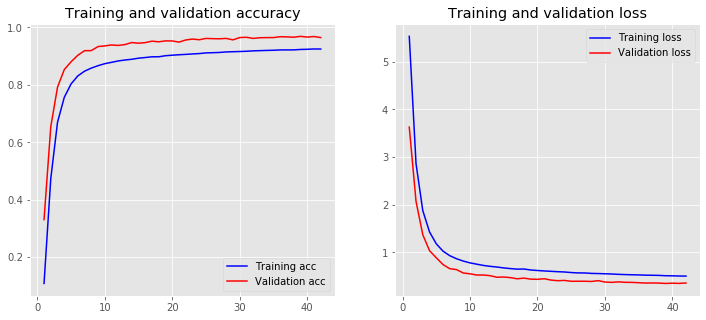

In [41]:
plot_history(history1)

In [ ]:
display_model_score(model1,
    [train_pad, y_train],
    [val_pad, y_val],
    [test_pad, y_test],
    256)

307968/439493 [====================>.........] - ETA: 1:01